In [1]:
!pip3 install opencv-python

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
import itertools
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

import cv2



2025-02-07 02:31:01.486703: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 02:31:03.334474: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 02:31:04.157574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738895464.872982   81925 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738895465.059171   81925 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 02:31:07.330186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
import tensorflow as tf
print(tf.__version__)

2.18.0


## Q1: Custom CNN Implementation for Image Classification (6 marks)

In [4]:
## Loading Dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
## Normalizing pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

In [6]:
x_train[0][0]

array([[0.23137255, 0.24313725, 0.24705882],
       [0.16862745, 0.18039216, 0.17647059],
       [0.19607843, 0.18823529, 0.16862745],
       [0.26666667, 0.21176471, 0.16470588],
       [0.38431373, 0.28627451, 0.20392157],
       [0.46666667, 0.35686275, 0.24705882],
       [0.54509804, 0.41960784, 0.29411765],
       [0.56862745, 0.43137255, 0.31372549],
       [0.58431373, 0.45882353, 0.34901961],
       [0.58431373, 0.47058824, 0.36470588],
       [0.51372549, 0.40392157, 0.30196078],
       [0.49019608, 0.38823529, 0.29803922],
       [0.55686275, 0.45098039, 0.35686275],
       [0.56470588, 0.43921569, 0.3372549 ],
       [0.5372549 , 0.41176471, 0.30980392],
       [0.50588235, 0.38039216, 0.27843137],
       [0.5372549 , 0.41568627, 0.30980392],
       [0.5254902 , 0.41568627, 0.29803922],
       [0.48627451, 0.38039216, 0.25098039],
       [0.54509804, 0.44313725, 0.30588235],
       [0.54509804, 0.43921569, 0.29411765],
       [0.52156863, 0.41176471, 0.27058824],
       [0.

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [8]:
## Train-Val Split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
## Data Augmentation
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(x_train)

In [9]:
## Initial baseline model setup
def create_model():
    model = models.Sequential()
    ## ip Conv Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu',strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    ## Conv layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu',strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))  ## for 10 labels
    return model

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/mnt/d/IIT Palakkad/SEM 2/Deep Learning/Labs/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1738895514.330324   81925 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 564,938 (2.16 MB)

 Trainable params: 564,682 (2.15 MB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
## Hyper-param tuned best model
def model_builder(hp):
    model = models.Sequential()
    ## ip Conv Layer
    model.add(layers.Conv2D(hp.Int('conv_fil_1', min_value=32, max_value=96,step=32),(3, 3), activation='relu',padding='same',input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    ## Additional Conv Layers
    for i in range(hp.Int('no_ex_conv_layers', 1, 2)):
        model.add(layers.Conv2D(hp.Int(f'conv_fil_{i+2}', min_value=32, max_value=64, step=32), (3, 3), activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        if hp.Boolean(f'maxpool_check_{i}'):
            model.add(layers.MaxPooling2D((2, 2)))

    ## Fully Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_lyr', min_value=128, max_value=256, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.1, max_value=0.7, step=0.1)))
    model.add(layers.Dense(10, activation='softmax'))
    ## Optimizer choice
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    model.compile(optimizer=optimizer,  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## hyperparam tuning
tuner = kt.RandomSearch( model_builder, objective='val_accuracy',max_trials=10, executions_per_trial=1, directory='cifar10_hp_tuning', project_name='cifar10_hp_tuning_model')
tuner.search(datagen.flow(x_train, y_train, batch_size=64), epochs=10,validation_data=(x_val, y_val))
# Fetch the best model
best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from cifar10_hp_tuning/cifar10_hp_tuning_model/tuner0.json


/mnt/d/IIT Palakkad/SEM 2/Deep Learning/Labs/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
optimizer_config = best_model.optimizer.get_config()
print("Optimizer:", best_model.optimizer.__class__.__name__)
print("Optimizer Config:", optimizer_config)

Optimizer: Adam
Optimizer Config: {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [12]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,842 (1.30 MB)

 Trainable params: 340,458 (1.30 MB)

 Non-trainable params: 384 (1.50 KB)

In [13]:
# Fit initial baseline model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data=(x_val, y_val))

# Fit huper param tuned model
tuned_history = best_model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data=(x_val, y_val))


Epoch 1/12


/mnt/d/IIT Palakkad/SEM 2/Deep Learning/Labs/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 62s 47ms/step - accuracy: 0.2788 - loss: 2.0637 - val_accuracy: 0.4381 - val_loss: 1.6072
Epoch 2/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.4331 - loss: 1.5482 - val_accuracy: 0.5435 - val_loss: 1.2912
Epoch 3/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 47ms/step - accuracy: 0.5081 - loss: 1.3692 - val_accuracy: 0.6155 - val_loss: 1.1181
Epoch 4/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.5549 - loss: 1.2578 - val_accuracy: 0.5608 - val_loss: 1.2344
Epoch 5/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.5782 - loss: 1.1953 - val_accuracy: 0.5778 - val_loss: 1.1897
Epoch 6/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.6084 - loss: 1.1186 - val_accuracy: 0.6019 - val_loss: 1.1368
Epoch 7/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.6307 - loss: 1.0549 - val_accuracy: 0.5826 - val_loss: 1.2730
Epoch 8/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.6477 - loss: 1.01

In [14]:
# Plot train/validn accuracy and loss curves vs epochs
def plot_curves(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc,  label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title(title+' Accuracy vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title(title+' loss vs Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

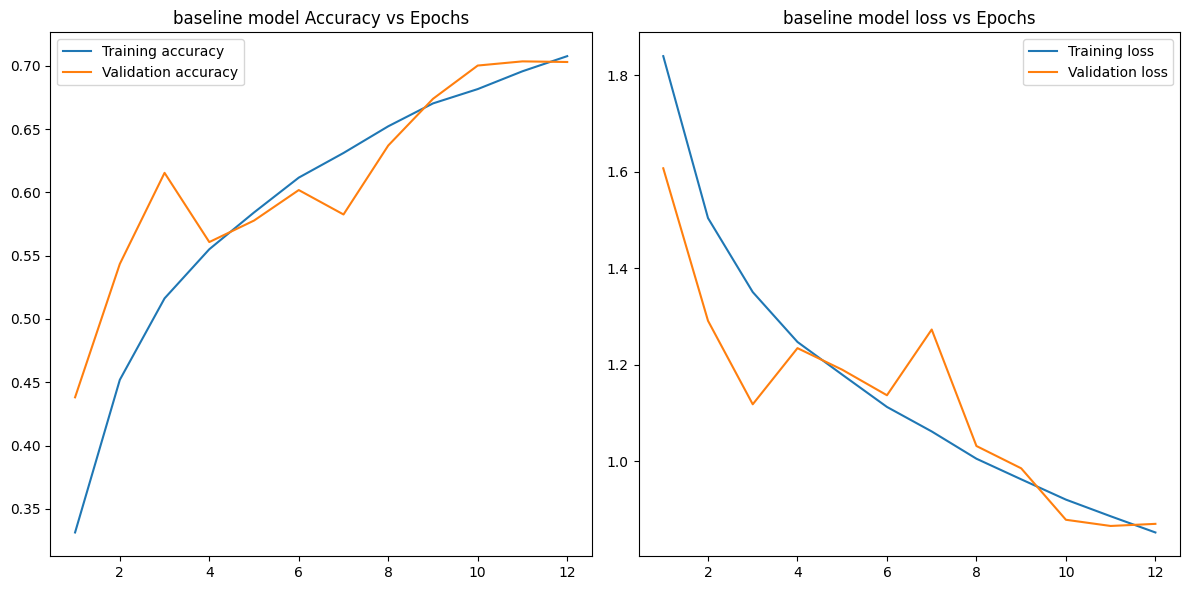

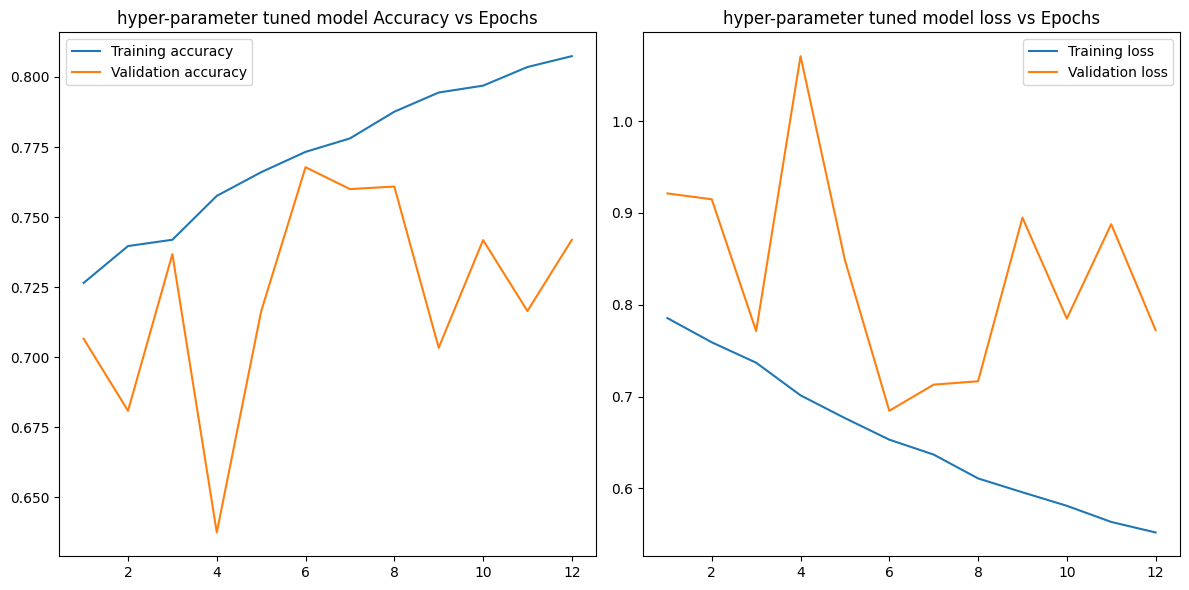

In [15]:
plot_curves(history, "baseline model")
plot_curves(tuned_history, "hyper-parameter tuned model")

### Observations: after 12 epochs model starts overfitting the training data and shows performance decline on validation data

In [16]:
## model performace evaluation
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Initial Model Test Loss:", loss)
print("Initial Model Test Accuracy:", accuracy)

loss, tuned_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print("Tuned Model Test Loss:", loss)
print("Tuned Model Test Accuracy:", tuned_accuracy)

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", cm)

cr = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", cr)

Initial Model Test Loss: 0.8843820095062256
Initial Model Test Accuracy: 0.7028999924659729
Tuned Model Test Loss: 0.7929653525352478
Tuned Model Test Accuracy: 0.7373999953269958
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Confusion Matrix:
 [[872   4  23  15   4   7   1  14  31  29]
 [ 30 829   3   6   1   3   5   4  18 101]
 [111   2 669  76  33  62  16  19   6   6]
 [ 51   1  79 622  24 144  27  33   8  11]
 [ 57   0 141  97 536  51  12  95   9   2]
 [ 21   1  47 196  10 677   5  34   2   7]
 [ 28   7  99 101  29  45 664   5  10  12]
 [ 25   0  34  44  19  52   0 814   3   9]
 [108  17  13  11   2   7   1   5 808  28]
 [ 35  26   8  16   0   3   1  13  15 883]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.87      0.75      1000
           1       0.93      0.83      0.88      1000
           2       0.60      0.67      0.63      1000
           3       0.53      0.62      0.57      1000
           4       0.81      0.54

### Observations: The custom hyperparameter tuned model performs better than the baseline model, having ~10% less loss and ~4% more accuracy as compared to the baseline model. This shows that the custom models results have more confidence in their model predictions due to the significantly lower loss value

# Q3: Task 3: Visualizing Model Decisions with Grad-CAM

In [24]:
!kaggle datasets download swaroopkml/cifar10-pngs-in-folders

Dataset URL: https://www.kaggle.com/datasets/swaroopkml/cifar10-pngs-in-folders
License(s): unknown
 83% 117M/140M [00:00<00:00, 167MB/s] 
100% 140M/140M [00:00<00:00, 153MB/s]


<ipython-input-27-6aa4dbc80ade>:48: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)  # Normalize
<ipython-input-27-6aa4dbc80ade>:56: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 scale


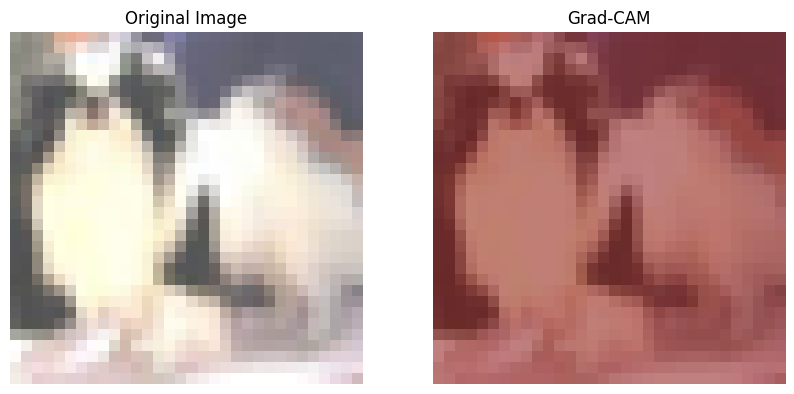

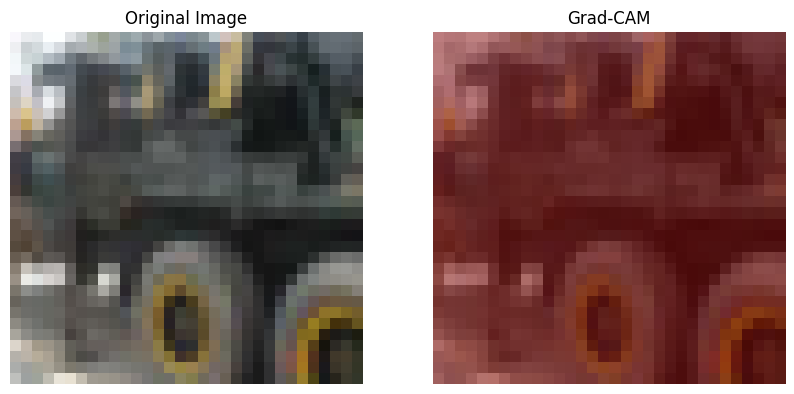

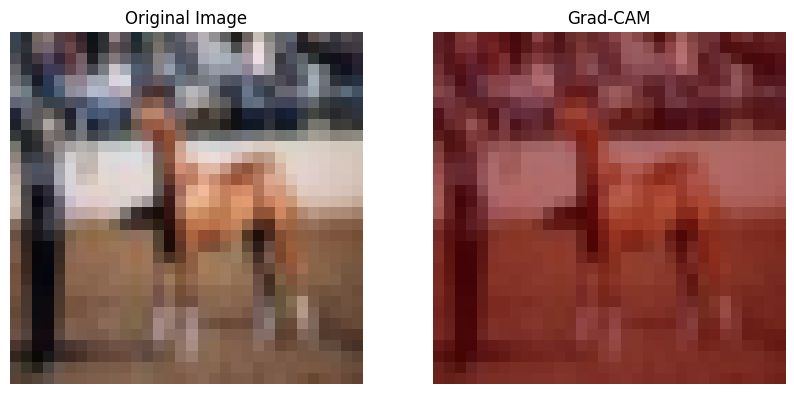

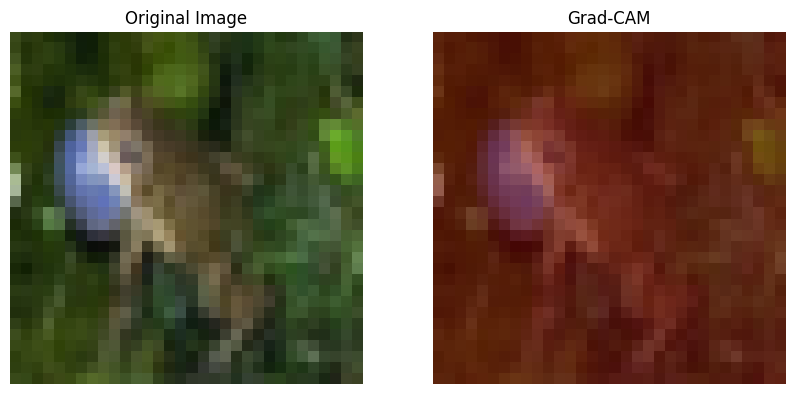

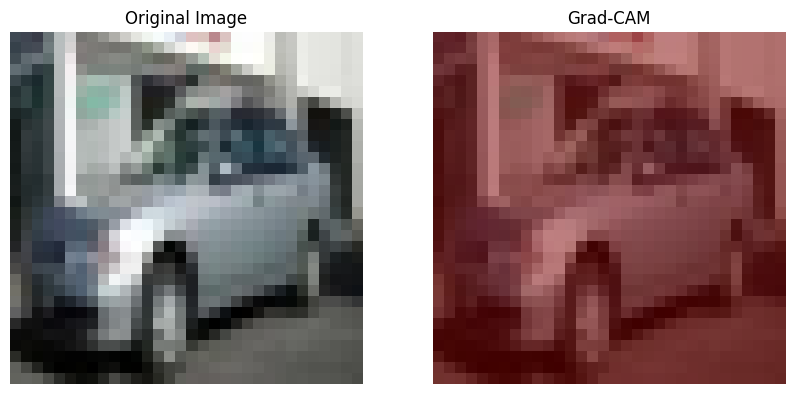

In [27]:
import keras
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import keras

def load_and_preprocess_image(img_path, target_size=(32, 32)):
    """Load and preprocess the input image."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array


def compute_gradcam(model, img_array, fin_conv_layer_name, op_layer_name , class_idx=None):
    """Compute Grad-CAM heatmap for a given class index."""
    grad_model = keras.models.Model([model.inputs],[model.get_layer(fin_conv_layer_name).output,model.get_layer(op_layer_name).output])

    # Forward pass
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        conv_outputs = tf.where(tf.math.is_nan(conv_outputs), tf.ones_like(conv_outputs), conv_outputs)
        if class_idx is None:
            class_idx = np.argmax(predictions[0])  # Get top predicted class
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        grads = tf.zeros_like(conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Convert tensors to NumPy for modification
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    # Apply Grad-CAM weighting
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Generate heatmap
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap


def overlay_heatmap(heatmap, img, alpha=0.5):
    """Overlay Grad-CAM heatmap on the original image."""
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 scale
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = np.array(img)
    overlayed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img

for img_path in [ "0904.png", "0265.png", "0978.png", "0984.png", "0990.png"]:
# Load and preprocess the image
  # img_path = "0904.png"
  img, img_array = load_and_preprocess_image(img_path)

  # Compute Grad-CAM
  heatmap = compute_gradcam(best_model, img_array, fin_conv_layer_name="conv2d_1", op_layer_name="dense_1")
  # compute_gradcam(best_model, img_array, layer_name="block5_conv3")

  # Overlay heatmap on original image
  overlayed_img = overlay_heatmap(heatmap, img)

  # Display results
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title("Original Image")
  plt.axis("off")

  plt.subplot(1, 2, 2)
  plt.imshow(overlayed_img)
  plt.title("Grad-CAM")
  plt.axis("off")

  plt.show()

## Observations: Since the input images are of low resolution(32 x 32), Grad-CAM shows that the custom CNN model in most of the cases considers the whole image to be important for decision making process 

# Q2:Task 2: Transfer Learning with Pre-trained Architectures

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn.model_selection import train_test_split
## Load Dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
## Train-Val Split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
## Data Aug
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(x_train)

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

def create_transfer_learning_model():
    base_model = VGG16(include_top=False, input_shape=(32, 32, 3), weights='imagenet')
    base_model.trainable = False  ## Freezing layers
    model = models.Sequential([
        base_model,
        ## Fully Connected Layer
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        ## op layer
        layers.Dense(10, activation='softmax')])
    return model


transfer_model = create_transfer_learning_model()

transfer_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = transfer_model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20, validation_data=(x_val, y_val))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.4258 - loss: 4.3797 - val_accuracy: 0.5377 - val_loss: 1.3534
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5921 - loss: 1.1834 - val_accuracy: 0.5745 - val_loss: 1.2587
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6258 - loss: 1.0812 - val_accuracy: 0.5855 - val_loss: 1.2454
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6479 - loss: 1.0219 - val_accuracy: 0.5908 - val_loss: 1.2734
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6618 - loss: 0.9765 - val_accuracy: 0.6036 - val_loss: 1.2573
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6758 - loss: 0.9382 - val_accuracy: 0.5940 - val_loss: 1.2904
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6916 - loss: 0.8899 - val_accuracy: 0.5904 - val_loss: 1.3180
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7041 - loss: 0.86

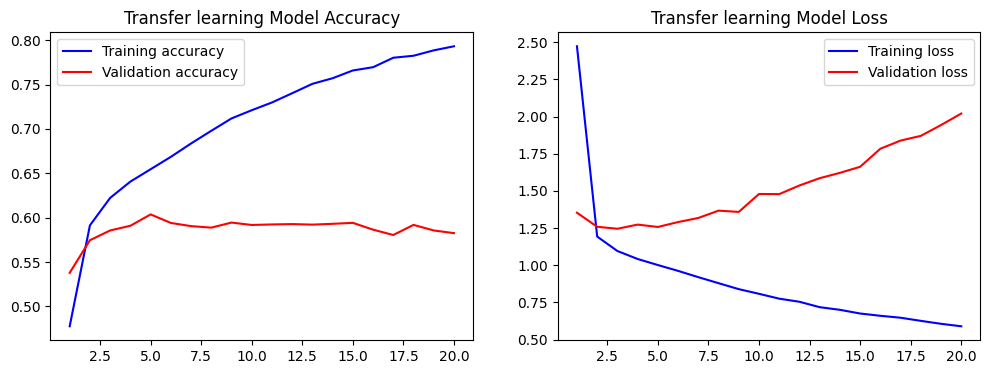

In [ ]:
plot_curves(history, "Transfer learning Model")

In [ ]:
y_pred = transfer_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_labels, y_pred_classes)
print("Confusion Matrix:\n", cm)
cr = classification_report(y_test_labels, y_pred_classes)
print("Classification Report:\n", cr)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Confusion Matrix:
 [[670  31  64  10  43   9  12  28 104  29]
 [ 36 667   9  26  21  18  23  20  68 112]
 [ 68  13 471  53 118  79  96  62  27  13]
 [ 34  40  81 350  95 182 107  52  30  29]
 [ 29  13 102  38 536  58 100  90  20  14]
 [ 13  29  64 156  71 512  52  70  16  17]
 [  9  24  59  67  83  48 679   8  11  12]
 [ 34  19  46  27 114  78  24 617  15  26]
 [ 88  70  10  14  25   8  12  19 705  49]
 [ 60 171  14  22  24  26   9  39  68 567]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.66      1000
           1       0.62      0.67      0.64      1000
           2       0.51      0.47      0.49      1000
           3       0.46      0.35      0.40      1000
           4       0.47      0.54      0.50      1000
           5       0.50      0.51      0.51      1000
           6       0.61      0.68      0.64      1000
           7       0.61      0.62      0.62      10

### Observations: Compared to the custom CNN model, the model performs worse when trained using transfer learning. This might be due to the fact that images in CIFAR-10 dataset are of 32 x 32 resolution wheras the VGG-16 model;s filters have been trained to work on more detailed 224 x 224 images. As a result the model maybe overfitting on the training data, causing a worse performance during testing